In [ ]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


prompt = "A cat is sitting, looking out the window"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/dog.jpg"
input_image = Image.open(image_path).convert('RGB')

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='txt2img')
loaded_state_dict = load_weights_from_ckpt('./weights/model/v1-5-pruned-emaonly.ckpt', device='cpu')
model.vae.load_state_dict(loaded_state_dict['vae'], strict=True)
model.unet.load_state_dict(loaded_state_dict['unet'], strict=True)
model.cond_encoder.load_state_dict(loaded_state_dict['cond_encoder'], strict=True)

tokenizer = CLIPTokenizer('./weights/tokenizer/tokenizer_vocab.json', merges_file='./weights/tokenizer/tokenizer_merges.txt')

In [ ]:
%load_ext autoreload
%autoreload 2
output_image = model.generate(
    input_image=None,
    img_size=(512, 512),
     prompt="A cozy mountain cabin at sunrise",
     uncond_promt=uncond_prompt,
     do_cfg=do_cfg,
     cfg_scale=cfg_scale,
     device='cpu',
     strength=0.2,
     inference_steps=num_inference_steps,
     sampler='ddpm',
     use_cosine_schedule=False,
     seed=seed,
     tokenizer=tokenizer
)

In [ ]:
Image.fromarray(output_image)

In [ ]:
torch.save(model.state_dict(), './quantized_model.pth')
os.path.getsize('./quantized_model.pth') / (1024 * 1024)

In [ ]:
%load_ext autoreload
%autoreload 2
!python3 train.py --device=mps --batch_size 16 --data_dir ./data/sprites/ --save_dir ./checkpoints/ --checkpoint_dir ./checkpoints/

In [10]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


cond = [[0, 0, 0, 0, 1]]
uncond = [[0, 0, 0, 0, 0]]   # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/image_6.JPEG"
input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='class2img', num_classes=5)
loaded_state_dict = torch.load('./weights/model/stable_diffusion_epoch_25.ckpt', map_location='cpu')['model_state_dict']
model.load_state_dict(loaded_state_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<All keys matched successfully>

In [98]:
%load_ext autoreload
%autoreload 2

output_image = model.generate_img_from_given_class(
    input_image=input_image,
    img_size=(16, 16),
    cond=[[0, 0, 0, 0, 1]],
     uncond=[[0, 0, 0, 0, 0]],
     do_cfg=False,
     cfg_scale=cfg_scale,
     device='cpu',
     strength=1.0,
     inference_steps=num_inference_steps,
     sampler='ddim',
     use_cosine_schedule=False,
     seed=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  2%|█▍                                                                   | 1/50 [00:00<00:14,  3.37it/s]

tensor(0.0668)


  4%|██▊                                                                  | 2/50 [00:00<00:13,  3.50it/s]

tensor(0.0724)


  6%|████▏                                                                | 3/50 [00:00<00:12,  3.72it/s]

tensor(0.0789)


  8%|█████▌                                                               | 4/50 [00:01<00:11,  3.88it/s]

tensor(0.0837)


 10%|██████▉                                                              | 5/50 [00:01<00:11,  3.95it/s]

tensor(0.0929)


 12%|████████▎                                                            | 6/50 [00:01<00:10,  4.02it/s]

tensor(0.1000)


 14%|█████████▋                                                           | 7/50 [00:01<00:10,  4.04it/s]

tensor(0.1062)


 16%|███████████                                                          | 8/50 [00:02<00:10,  4.06it/s]

tensor(0.1184)


 18%|████████████▍                                                        | 9/50 [00:02<00:10,  4.04it/s]

tensor(0.1310)


 20%|█████████████▌                                                      | 10/50 [00:02<00:09,  4.06it/s]

tensor(0.1382)


 22%|██████████████▉                                                     | 11/50 [00:02<00:09,  4.07it/s]

tensor(0.1549)


 24%|████████████████▎                                                   | 12/50 [00:03<00:09,  4.07it/s]

tensor(0.1685)


 26%|█████████████████▋                                                  | 13/50 [00:03<00:09,  4.11it/s]

tensor(0.1769)


 28%|███████████████████                                                 | 14/50 [00:03<00:08,  4.13it/s]

tensor(0.1966)


 30%|████████████████████▍                                               | 15/50 [00:03<00:08,  3.91it/s]

tensor(0.2122)


 32%|█████████████████████▊                                              | 16/50 [00:04<00:09,  3.70it/s]

tensor(0.2286)


 34%|███████████████████████                                             | 17/50 [00:04<00:09,  3.35it/s]

tensor(0.2534)


 36%|████████████████████████▍                                           | 18/50 [00:04<00:09,  3.47it/s]

tensor(0.2717)


 38%|█████████████████████████▊                                          | 19/50 [00:04<00:08,  3.66it/s]

tensor(0.2824)


 40%|███████████████████████████▏                                        | 20/50 [00:05<00:07,  3.78it/s]

tensor(0.3007)


 42%|████████████████████████████▌                                       | 21/50 [00:05<00:07,  3.69it/s]

tensor(0.3243)


 44%|█████████████████████████████▉                                      | 22/50 [00:05<00:08,  3.47it/s]

tensor(0.3463)


 46%|███████████████████████████████▎                                    | 23/50 [00:06<00:07,  3.41it/s]

tensor(0.3613)


 48%|████████████████████████████████▋                                   | 24/50 [00:06<00:08,  3.23it/s]

tensor(0.3852)


 50%|██████████████████████████████████                                  | 25/50 [00:06<00:07,  3.32it/s]

tensor(0.3978)


 52%|███████████████████████████████████▎                                | 26/50 [00:07<00:07,  3.19it/s]

tensor(0.4177)


 54%|████████████████████████████████████▋                               | 27/50 [00:07<00:06,  3.33it/s]

tensor(0.4323)


 56%|██████████████████████████████████████                              | 28/50 [00:07<00:06,  3.52it/s]

tensor(0.4478)


 58%|███████████████████████████████████████▍                            | 29/50 [00:07<00:05,  3.69it/s]

tensor(0.4599)


 60%|████████████████████████████████████████▊                           | 30/50 [00:08<00:05,  3.81it/s]

tensor(0.4847)


 62%|██████████████████████████████████████████▏                         | 31/50 [00:08<00:04,  3.87it/s]

tensor(0.4992)


 64%|███████████████████████████████████████████▌                        | 32/50 [00:08<00:04,  3.70it/s]

tensor(0.5115)


 66%|████████████████████████████████████████████▉                       | 33/50 [00:08<00:04,  3.56it/s]

tensor(0.5180)


 68%|██████████████████████████████████████████████▏                     | 34/50 [00:09<00:04,  3.67it/s]

tensor(0.5231)


 70%|███████████████████████████████████████████████▌                    | 35/50 [00:09<00:03,  3.79it/s]

tensor(0.5358)


 72%|████████████████████████████████████████████████▉                   | 36/50 [00:09<00:03,  3.76it/s]

tensor(0.5454)


 74%|██████████████████████████████████████████████████▎                 | 37/50 [00:09<00:03,  3.84it/s]

tensor(0.5505)


 76%|███████████████████████████████████████████████████▋                | 38/50 [00:10<00:03,  3.89it/s]

tensor(0.5531)


 78%|█████████████████████████████████████████████████████               | 39/50 [00:10<00:02,  3.97it/s]

tensor(0.5435)


 80%|██████████████████████████████████████████████████████▍             | 40/50 [00:10<00:02,  4.00it/s]

tensor(0.5499)


 82%|███████████████████████████████████████████████████████▊            | 41/50 [00:10<00:02,  4.05it/s]

tensor(0.5583)


 84%|█████████████████████████████████████████████████████████           | 42/50 [00:11<00:01,  4.07it/s]

tensor(0.5575)


 86%|██████████████████████████████████████████████████████████▍         | 43/50 [00:11<00:01,  4.06it/s]

tensor(0.5469)


 88%|███████████████████████████████████████████████████████████▊        | 44/50 [00:11<00:01,  3.85it/s]

tensor(0.5430)


 90%|█████████████████████████████████████████████████████████████▏      | 45/50 [00:11<00:01,  3.88it/s]

tensor(0.5375)


 92%|██████████████████████████████████████████████████████████████▌     | 46/50 [00:12<00:01,  3.93it/s]

tensor(0.5282)


 94%|███████████████████████████████████████████████████████████████▉    | 47/50 [00:12<00:00,  3.97it/s]

tensor(0.5312)


 96%|█████████████████████████████████████████████████████████████████▎  | 48/50 [00:12<00:00,  3.96it/s]

tensor(0.5232)


 98%|██████████████████████████████████████████████████████████████████▋ | 49/50 [00:12<00:00,  3.98it/s]

tensor(0.5026)


100%|████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.79it/s]

tensor(0.5197)


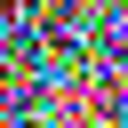

In [99]:
output_image.resize((128, 128))

In [96]:
%load_ext autoreload
%autoreload 2
!python3 train.py --device=mps --batch_size 32 --data_dir ./data/sprites/ --save_dir ./checkpoints/ --checkpoint_dir ./checkpoints/ --pretrained ./weights/model/stable_diffusion_epoch_25.ckpt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
^C
Traceback (most recent call last):
  File "train.py", line 1, in <module>
    from models.diffusion import StableDiffusion
  File "/Users/dnnhhuy/Study/pytorch-course/txt2img-stable-diffusion/models/diffusion.py", line 3, in <module>
    from torchvision import transforms
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/torchvision/__init__.py", line 6, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/torchvision/models/convnext.py", line 8, in <module>
    from ..ops.misc import Conv2dNormActivation, Permute
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/t